<a href="https://colab.research.google.com/github/Dianna22/pytorch-sentiment-analysis/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Updated Sentiment Analysis

In the previous notebook, we got the fundamentals down for sentiment analysis. In this notebook, we'll actually get decent results.

We will use:
- packed padded sequences
- pre-trained word embeddings
- different RNN architecture
- bidirectional RNN
- multi-layer RNN
- regularization
- a different optimizer

This will allow us to achieve ~84% test accuracy.

## Preparing Data

As before, we'll set the seed, define the `Fields` and get the train/valid/test splits.

We'll be using *packed padded sequences*, which will make our RNN only process the non-padded elements of our sequence, and for any padded element the `output` will be a zero tensor. To use packed padded sequences, we have to tell the RNN how long the actual sequences are. We do this by setting `include_lengths = True` for our `TEXT` field. This will cause `batch.text` to now be a tuple with the first element being our sentence (a numericalized tensor that has been padded) and the second element being the actual lengths of our sentences.

In [0]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

We then load the IMDb dataset.

In [0]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

Then create the validation set from our training set.

In [0]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors.
We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"glove.6B.100d" vectors"`. `glove` is the algorithm used to calculate the vectors, go [here](https://nlp.stanford.edu/projects/glove/) for more. `6B` indicates these vectors were trained on 6 billion tokens and `100d` indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

**Note**: these vectors are about 862MB, so watch out if you have a limited internet connection.

By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting `unk_init` to `torch.Tensor.normal_`. This will now initialize those words via a Gaussian distribution.

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

As before, we create the iterators, placing the tensors on the GPU if one is available.

Another thing for packed padded sequences all of the tensors within a batch need to be sorted by their lengths. This is handled in the iterator by setting `sort_within_batch = True`.

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

The model features the most drastic changes.

### Different RNN Architecture

We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? Standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like (with the embedding layers omitted):

![](https://github.com/Dianna22/pytorch-sentiment-analysis/blob/master/assets/sentiment2.png?raw=1)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$. 

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. 

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](https://github.com/Dianna22/pytorch-sentiment-analysis/blob/master/assets/sentiment3.png?raw=1)

### Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](https://github.com/Dianna22/pytorch-sentiment-analysis/blob/master/assets/sentiment4.png?raw=1)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into too much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing  a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`text` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths`, to `forward`. 

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` and `cell` states (both of which are tensors). Without packed padded sequences, `hidden` and `cell` are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. 

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

#### Vocabulary


In [0]:
corpus = {} # doc_label: {word: word_freq_df}
df = {}
for instance in train_data.examples:
  for word in instance.text:
    word = word.lower()
    df[word] = df.get(word,0)+1
    corpus[instance.label] = corpus.get(instance.label, {}) # {word: df}
    corpus[instance.label][word] = corpus[instance.label].get(word, 0) + 1


In [0]:
def compute_tf_idf(word, doc, doc_freq):
  tf = doc_freq[doc][word]/sum(doc_freq[doc].values())
  df = len([doc for doc in corpus.keys() if word if corpus[doc]])
  idf = 2/df
  return tf * idf

In [258]:
import math

tf_idf = {} # {doc(label): {word:score}}
N = len(corpus)
print(N, "classes")
for doc in corpus.keys():
  tf_idf[doc] = tf_idf.get(doc,{})
  for word in corpus[doc]:
    word = word.lower()
    tf_idf[doc][word] = compute_tf_idf(word, doc, corpus)

2 classes


In [0]:
sorted_words = {doc: [key for key in sorted(tf_idf[doc].keys(), key=tf_idf[doc].get, reverse=True)] for doc in tf_idf.keys()} 

In [260]:
tf_idf['neg']['the']

0.04740838874962306

In [261]:
max(tf_idf['neg'].values())

0.04740838874962306

In [262]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words('english'))

In [0]:
def get_vocab(sentiment):
  ignore_set = set(string.punctuation).union(set('0123456789'))
  return [word for word in sorted_words[sentiment] if word not in stop_words and not set(word).intersection(ignore_set)]

In [0]:
neg_vocab = get_vocab('neg')
pos_vocab = get_vocab('pos')

In [0]:
from nltk import sentiment

In [267]:
pip install vaderSentiment

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [0]:
n_vocab = [word for word in neg_vocab if analyser.polarity_scores(word)['neu'] != 1]
p_vocab = [word for word in pos_vocab if analyser.polarity_scores(word)['neu'] != 1]

In [0]:
VOCAB_LIST = n_vocab[:100]+p_vocab[:100]

In [0]:
VOCAB = [TEXT.vocab.stoi[word] for word in VOCAB_LIST]

In [0]:
a=['like',
 'good',
 'bad',
 'well',
 'better',
 'great',
 'worst',
 'funny',
 'want',
 'love',
 'pretty',
 'best',
 'horror',
 'original',
 'interesting',
 'kind',
 'awful',
 'comedy',
 'boring',
 'terrible',
 'poor',
 'hard',
 'stupid',
 'sure',
 'waste',
 'low',
 'worse',
 'wrong',
 'special',
 'dead',
 'played',
 'worth',
 'horrible',
 'play',
 'fun',
 'problem',
 'death',
 'help',
 'nice',
 'killer',
 'fan',
 'plays',
 'unfortunately',
 'true',
 'care',
 'crap',
 'friends',
 'ridiculous',
 'annoying',
 'top',
 'evil',
 'laugh',
 'playing',
 'save',
 'kill',
 'god',
 'lost',
 'yes',
 'truly',
 'war',
 'lack',
 'ok',
 'killed',
 'dull',
 'hand',
 'seriously',
 'recommend',
 'enjoy',
 'lame',
 'hope',
 '\x96',
 'hell',
 'certainly',
 'cut',
 'friend',
 'please',
 'stop',
 'jokes',
 'liked',
 'avoid',
 'scary',
 'beautiful',
 'leave',
 'badly',
 'violence',
 'b',
 'humor',
 'silly',
 'fight',
 'hero',
 'entertaining',
 'sorry',
 'huge',
 'interest',
 'alone',
 'disappointed',
 'weak',
 'matter',
 'feeling',
 'definitely',
 'like',
 'good',
 'great',
 'well',
 'love',
 'best',
 'better',
 'funny',
 'bad',
 'comedy',
 'fun',
 'excellent',
 'beautiful',
 'played',
 'pretty',
 'want',
 'horror',
 'interesting',
 'true',
 'plays',
 'wonderful',
 'original',
 'hard',
 'sure',
 'play',
 'kind',
 'perfect',
 'war',
 'worth',
 'enjoy',
 'nice',
 'definitely',
 'amazing',
 'loved',
 'top',
 'help',
 'truly',
 'special',
 'recommend',
 'favorite',
 'friends',
 'fan',
 'death',
 'playing',
 'brilliant',
 'liked',
 'enjoyed',
 'fine',
 'friend',
 'strong',
 'lost',
 'hope',
 'certainly',
 'entertaining',
 'dead',
 'humor',
 'evil',
 'yes',
 'fantastic',
 'supporting',
 '\x96',
 'wrong',
 'murder',
 'low',
 'chance',
 'greatest',
 'feeling',
 'hand',
 'happy',
 'romantic',
 'laugh',
 'hilarious',
 'matter',
 'number',
 'fight',
 'important',
 'enjoyable',
 'miss',
 'superb',
 'novel',
 'leave',
 'killer',
 'care',
 'wish',
 'hero',
 'violence',
 'problem',
 'perfectly',
 'thriller',
 'serious',
 'easy',
 'strange',
 'easily',
 'surprised',
 'alone',
 'sad',
 'powerful',
 'stop',
 'crime',
 'interest']

In [273]:
str([ f"{len(a)-i} {word}" for i, word in enumerate(a)]).replace("'","").replace(",","")

'[200 like 199 good 198 bad 197 well 196 better 195 great 194 worst 193 funny 192 want 191 love 190 pretty 189 best 188 horror 187 original 186 interesting 185 kind 184 awful 183 comedy 182 boring 181 terrible 180 poor 179 hard 178 stupid 177 sure 176 waste 175 low 174 worse 173 wrong 172 special 171 dead 170 played 169 worth 168 horrible 167 play 166 fun 165 problem 164 death 163 help 162 nice 161 killer 160 fan 159 plays 158 unfortunately 157 true 156 care 155 crap 154 friends 153 ridiculous 152 annoying 151 top 150 evil 149 laugh 148 playing 147 save 146 kill 145 god 144 lost 143 yes 142 truly 141 war 140 lack 139 ok 138 killed 137 dull 136 hand 135 seriously 134 recommend 133 enjoy 132 lame 131 hope 130 \\x96 129 hell 128 certainly 127 cut 126 friend 125 please 124 stop 123 jokes 122 liked 121 avoid 120 scary 119 beautiful 118 leave 117 badly 116 violence 115 b 114 humor 113 silly 112 fight 111 hero 110 entertaining 109 sorry 108 huge 107 interest 106 alone 105 disappointed 104 wea

#### CNN

In [0]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import pdb

class CNN(nn.Module):

    def __init__(self, embedding_dim, filter_num, filters, num_layers, max_pool_over_time=False):
        super(CNN, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.layers = []
        for layer in range(num_layers):
            convs = []
            for filt in filters:
                in_channels =  embedding_dim if layer == 0 else filter_num * len(filters)
                kernel_size = filt
                new_conv = nn.Conv1d(in_channels=in_channels, out_channels=filter_num, kernel_size=kernel_size)
                self.add_module( 'layer_'+str(layer)+'_conv_'+str(filt), new_conv)
                convs.append(new_conv)

            self.layers.append(convs)

        self.max_pool = max_pool_over_time



    def _conv(self, x):
        layer_activ = x
        for layer in self.layers:
            next_activ = []
            for conv in layer:
                left_pad = conv.kernel_size[0] - 1
                pad_tensor_size = [d for d in layer_activ.size()]
                pad_tensor_size[2] = left_pad
                left_pad_tensor =torch.zeros( pad_tensor_size, device=self.device)
                padded_activ = torch.cat( (left_pad_tensor, layer_activ), dim=2)
                next_activ.append( conv(padded_activ) )

            # concat across channels
            layer_activ = F.relu( torch.cat(next_activ, 1) )

        return layer_activ


    def _pool(self, relu):
        pool = F.max_pool1d(relu, relu.size(2)).squeeze(-1)
        return pool


    def forward(self, x):
        print(x.size())
        activ = self._conv(x)
        if self.max_pool:
            activ =  self._pool(activ)
        return activ

#### Model

In [0]:
# vocab=torch.tensor([[1,1.0],
#                     [2,2],
#                     [3,3]])
# mask = torch.tensor([[0.1,0.2,0.8],[0.1,0.2,0.181],[0.1,0.02,0.8],[0.1,0.2,0.08],[0.1,0.92,0.68]])
# print(mask.unsqueeze(-1))
# mask = mask.unsqueeze(2)
# print(mask)
# vocab = vocab.repeat(5,1,1)
# batch_vocab=torch.mul(vocab, mask)
# print(batch_vocab.size())

In [0]:
# x=torch.tensor([
#                 [[1,2],[12,1.0], [1,2],[3,4]],
#                 [[1,2],[12,1.0], [1,2],[3,4]],
#                 [[1,2],[12,1.0], [1,2],[3,4]],
#                 [[1,2],[12,1.0], [1,2],[3,4]],
#                 [[1,2],[12,1.0], [1,2],[3,4]]
#                 ])
# print(x.size())
# torch.cat((x,,vocab),1).size()


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx, explanation_vocab):
        
        super().__init__()
        self.emb_dim = embedding_dim
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.gen = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)


        self.expl_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # self.gen = CNN(embedding_dim, 100, [3,4,5],1)
        self.gen_lin = nn.Linear(2*hidden_dim, len(explanation_vocab))
        self.gen_softmax = nn.Softmax(2)      
        self.explanations = torch.tensor(explanation_vocab, device=self.device)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        batch_size = text.size()[1]
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        ##GEN
        # [sent len, batch, 2*hidden_dim]
        expl_activ, (_, _) = self.gen(embedded)
        # [sent, batch, vocab]
        lin_activ = self.gen_lin(expl_activ)
        # [sent, batch, vocab]
        expl_distribution = self.gen_softmax(lin_activ)
        
        # [batch, sent, vocab]
        expl_distribution = torch.transpose(expl_distribution, 0, 1)

        # [vocab_size, emb_dim]
        v_emb = self.expl_emb(self.explanations)

        #[batch, vocab_size, emd_dim]
        vocab_emb = v_emb.repeat(batch_size,1,1)

        
        # [batch,sent, emb_dim]
        expl = torch.bmm(expl_distribution, vocab_emb)

        #[batch, 1, emb_dim]
        context_vector = torch.mean(expl, dim=1).unsqueeze(1)

        sep = torch.rand((batch_size,1,self.emb_dim), device=self.device)
        # [batch, 1+1, emb_dim]
        sep_vocab = torch.cat((sep, context_vector),1)

        #[batch, sent, emb]
        x = torch.transpose(embedded,0,1)

        # [batch, sent_len+2, emb_dim]
        concat_input = torch.cat((x,sep_vocab),1) 

        #[sent_len+1, batch, emb_dim]
        final_input = torch.transpose(concat_input,0,1)
        
        packed_all = nn.utils.rnn.pack_padded_sequence(final_input, text_lengths+2)
        
        packed_output, (hidden, cell) = self.rnn(packed_all)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden), expl_distribution

Like before, we'll create an instance of our RNN class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.

To ensure the pre-trained vectors can be loaded into the model, the `EMBEDDING_DIM` must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's `pad_token` attribute, which is `<pad>` by default.

In [691]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX,
            VOCAB)
print(len(VOCAB))

200


We'll print out the number of parameters in our model. 

Notice how we have almost twice as many parameters as before!

In [692]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,723,801 trainable parameters


The final addition is copying the pre-trained word embeddings we loaded earlier into the `embedding` layer of our model.

We retrieve the embeddings from the field's vocab, and check they're the correct size, _**[vocab size, embedding dim]**_ 

In [693]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


We then replace the initial weights of the `embedding` layer with the pre-trained embeddings.

**Note**: this should always be done on the `weight.data` and not the `weight`!

In [694]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2679,  0.4653, -0.2344,  ...,  0.0435, -0.2381, -0.2891],
        [-1.7097, -1.0844, -1.9910,  ...,  0.9195, -0.5529, -0.1304],
        [ 0.7669, -0.0796, -0.2085,  ..., -0.4254,  0.3508, -0.5666]])

As our `<unk>` and `<pad>` token aren't in the pre-trained vocabulary they have been initialized using `unk_init` (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment. 

We do this by manually setting their row in the embedding weights matrix to zeros. We get their row by finding the index of the tokens, which we have already done for the padding index.

**Note**: like initializing the embeddings, this should be done on the `weight.data` and not the `weight`!

In [695]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2679,  0.4653, -0.2344,  ...,  0.0435, -0.2381, -0.2891],
        [-1.7097, -1.0844, -1.9910,  ...,  0.9195, -0.5529, -0.1304],
        [ 0.7669, -0.0796, -0.2085,  ..., -0.4254,  0.3508, -0.5666]])


We can now see the first two rows of the embedding weights matrix have been set to zeros. As we passed the index of the pad token to the `padding_idx` of the embedding layer it will remain zeros throughout training, however the `<unk>` token embedding will be learned.

## Train the Model

#### Train prep


Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. `Adam` adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about `Adam` (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam`, also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile default initial learning rate.

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

The rest of the steps for training the model are unchanged.

We define the criterion and place the model and criterion on the GPU (if available)...

In [0]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model. 

As we have set `include_lengths = True`, our `batch.text` is now a tuple with the first element being the numericalized tensor and the second element being the actual lengths of each sequence. We separate these into their own variables, `text` and `text_lengths`, before passing them to the model.

**Note**: as we are now using dropout, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in tqdm.tqdm(iterator):
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions, expl = model(text, text_lengths)
        predictions = predictions.squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Then we define a function for testing our model, again remembering to separate `batch.text`.

**Note**: as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions, expl = model(text, text_lengths)
            predictions = predictions.squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

And also create a nice function to tell us how long our epochs are taking.

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

#### Train

In [702]:
pip install tqdm

In [703]:
import tqdm
N_EPOCHS = 15
tr_loss = []
val_loss= []
train_accs, val_accs = [], []
best_valid_loss = float('inf')
prev=123
for epoch in  tqdm.tqdm(range(N_EPOCHS)):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    train_accs.append(train_acc)
    val_accs.append(valid_acc)
    tr_loss.append(train_loss)
    val_loss.append(valid_loss)
    if valid_loss > prev:
      break
    prev = valid_loss






  0%|          | 0/15 [00:00<?, ?it/s]





  0%|          | 0/274 [00:00<?, ?it/s]





  0%|          | 1/274 [00:00<03:26,  1.32it/s]





  1%|          | 2/274 [00:01<03:03,  1.48it/s]





  1%|          | 3/274 [00:01<03:02,  1.49it/s]





  1%|▏         | 4/274 [00:02<03:17,  1.37it/s]





  2%|▏         | 5/274 [00:03<02:52,  1.56it/s]





  2%|▏         | 6/274 [00:03<02:20,  1.90it/s]





  3%|▎         | 7/274 [00:04<02:25,  1.83it/s]





  3%|▎         | 8/274 [00:04<02:46,  1.60it/s]





  3%|▎         | 9/274 [00:06<03:29,  1.26it/s]





  4%|▎         | 10/274 [00:06<02:53,  1.52it/s]





  4%|▍         | 11/274 [00:06<02:34,  1.70it/s]





  4%|▍         | 12/274 [00:07<02:36,  1.67it/s]





  5%|▍         | 13/274 [00:09<03:55,  1.11it/s]





  5%|▌         | 14/274 [00:09<03:57,  1.10it/s]





  5%|▌         | 15/274 [00:11<04:11,  1.03it/s]





  6%|▌         | 16/274 [00:11<03:48,  1.13it/s]





  6%|▌         | 17/274 [00:12<03:25,  1.25it/s]




Epoch: 01 | Epoch Time: 3m 22s
	Train Loss: 0.671 | Train Acc: 58.99%
	 Val. Loss: 0.652 |  Val. Acc: 63.11%








  0%|          | 1/274 [00:00<01:36,  2.83it/s]





  1%|          | 2/274 [00:00<01:37,  2.80it/s]





  1%|          | 3/274 [00:02<03:13,  1.40it/s]





  1%|▏         | 4/274 [00:02<03:11,  1.41it/s]





  2%|▏         | 5/274 [00:03<02:28,  1.81it/s]





  2%|▏         | 6/274 [00:04<03:35,  1.24it/s]





  3%|▎         | 7/274 [00:04<02:42,  1.64it/s]





  3%|▎         | 8/274 [00:05<02:31,  1.76it/s]





  3%|▎         | 9/274 [00:05<02:46,  1.60it/s]





  4%|▎         | 10/274 [00:06<02:22,  1.86it/s]





  4%|▍         | 11/274 [00:07<02:51,  1.53it/s]





  4%|▍         | 12/274 [00:07<02:11,  1.99it/s]





  5%|▍         | 13/274 [00:07<02:02,  2.13it/s]





  5%|▌         | 14/274 [00:08<02:12,  1.96it/s]





  5%|▌         | 15/274 [00:08<02:18,  1.87it/s]





  6%|▌         | 16/274 [00:09<02:13,  1.94it/s]





  6%|▌         | 17/274 [00:10<02:44,  1.56it/s]





  7%|▋         | 18/274 [00:11<03:36,  1.18it/s]





  7%|▋         | 19/274 [00:12<

Epoch: 02 | Epoch Time: 3m 22s
	Train Loss: 0.605 | Train Acc: 67.70%
	 Val. Loss: 0.533 |  Val. Acc: 73.10%








  0%|          | 1/274 [00:00<02:03,  2.22it/s]





  1%|          | 2/274 [00:01<03:10,  1.43it/s]





  1%|          | 3/274 [00:02<03:04,  1.47it/s]





  1%|▏         | 4/274 [00:03<03:43,  1.21it/s]





  2%|▏         | 5/274 [00:04<03:33,  1.26it/s]





  2%|▏         | 6/274 [00:05<03:45,  1.19it/s]





  3%|▎         | 7/274 [00:05<03:13,  1.38it/s]





  3%|▎         | 8/274 [00:06<02:53,  1.53it/s]





  3%|▎         | 9/274 [00:06<02:38,  1.68it/s]





  4%|▎         | 10/274 [00:06<02:06,  2.09it/s]





  4%|▍         | 11/274 [00:07<02:19,  1.89it/s]





  4%|▍         | 12/274 [00:07<02:08,  2.04it/s]





  5%|▍         | 13/274 [00:08<02:11,  1.99it/s]





  5%|▌         | 14/274 [00:09<02:25,  1.79it/s]





  5%|▌         | 15/274 [00:11<04:28,  1.04s/it]





  6%|▌         | 16/274 [00:11<03:51,  1.11it/s]





  6%|▌         | 17/274 [00:12<03:21,  1.27it/s]





  7%|▋         | 18/274 [00:13<03:37,  1.18it/s]





  7%|▋         | 19/274 [00:13<

Epoch: 03 | Epoch Time: 3m 22s
	Train Loss: 0.474 | Train Acc: 78.32%
	 Val. Loss: 0.481 |  Val. Acc: 80.02%








  0%|          | 1/274 [00:00<02:25,  1.88it/s]





  1%|          | 2/274 [00:00<02:16,  2.00it/s]





  1%|          | 3/274 [00:01<02:01,  2.23it/s]





  1%|▏         | 4/274 [00:02<03:22,  1.33it/s]





  2%|▏         | 5/274 [00:02<02:33,  1.75it/s]





  2%|▏         | 6/274 [00:03<02:17,  1.95it/s]





  3%|▎         | 7/274 [00:04<03:22,  1.32it/s]





  3%|▎         | 8/274 [00:06<04:24,  1.00it/s]





  3%|▎         | 9/274 [00:07<04:23,  1.00it/s]





  4%|▎         | 10/274 [00:07<03:36,  1.22it/s]





  4%|▍         | 11/274 [00:09<05:03,  1.15s/it]





  4%|▍         | 12/274 [00:09<04:01,  1.09it/s]





  5%|▍         | 13/274 [00:10<03:18,  1.32it/s]





  5%|▌         | 14/274 [00:10<02:45,  1.57it/s]





  5%|▌         | 15/274 [00:11<02:56,  1.46it/s]





  6%|▌         | 16/274 [00:11<02:16,  1.89it/s]





  6%|▌         | 17/274 [00:11<02:02,  2.10it/s]





  7%|▋         | 18/274 [00:12<01:50,  2.32it/s]





  7%|▋         | 19/274 [00:12<

Epoch: 04 | Epoch Time: 3m 22s
	Train Loss: 0.379 | Train Acc: 83.60%
	 Val. Loss: 0.396 |  Val. Acc: 81.59%








  0%|          | 1/274 [00:00<02:26,  1.87it/s]





  1%|          | 2/274 [00:01<02:43,  1.66it/s]





  1%|          | 3/274 [00:01<02:30,  1.80it/s]





  1%|▏         | 4/274 [00:02<02:15,  1.99it/s]





  2%|▏         | 5/274 [00:02<02:02,  2.20it/s]





  2%|▏         | 6/274 [00:04<03:29,  1.28it/s]





  3%|▎         | 7/274 [00:04<03:15,  1.36it/s]





  3%|▎         | 8/274 [00:06<04:28,  1.01s/it]





  3%|▎         | 9/274 [00:06<03:33,  1.24it/s]





  4%|▎         | 10/274 [00:07<03:17,  1.34it/s]





  4%|▍         | 11/274 [00:08<03:36,  1.21it/s]





  4%|▍         | 12/274 [00:08<03:30,  1.24it/s]





  5%|▍         | 13/274 [00:09<03:23,  1.28it/s]





  5%|▌         | 14/274 [00:10<02:58,  1.46it/s]





  5%|▌         | 15/274 [00:10<02:41,  1.61it/s]





  6%|▌         | 16/274 [00:12<04:24,  1.02s/it]





  6%|▌         | 17/274 [00:13<03:46,  1.14it/s]





  7%|▋         | 18/274 [00:13<03:21,  1.27it/s]





  7%|▋         | 19/274 [00:14<

Epoch: 05 | Epoch Time: 3m 22s
	Train Loss: 0.310 | Train Acc: 87.36%
	 Val. Loss: 0.297 |  Val. Acc: 88.14%








  0%|          | 1/274 [00:00<01:00,  4.50it/s]





  1%|          | 2/274 [00:01<02:40,  1.70it/s]





  1%|          | 3/274 [00:02<03:01,  1.49it/s]





  1%|▏         | 4/274 [00:03<02:51,  1.57it/s]





  2%|▏         | 5/274 [00:03<02:23,  1.87it/s]





  2%|▏         | 6/274 [00:04<03:44,  1.20it/s]





  3%|▎         | 7/274 [00:06<04:19,  1.03it/s]





  3%|▎         | 8/274 [00:06<03:33,  1.25it/s]





  3%|▎         | 9/274 [00:06<02:41,  1.64it/s]





  4%|▎         | 10/274 [00:07<03:13,  1.37it/s]





  4%|▍         | 11/274 [00:08<03:26,  1.28it/s]





  4%|▍         | 12/274 [00:09<03:02,  1.43it/s]





  5%|▍         | 13/274 [00:14<08:43,  2.00s/it]





  5%|▌         | 14/274 [00:15<07:51,  1.81s/it]





  5%|▌         | 15/274 [00:16<06:13,  1.44s/it]





  6%|▌         | 16/274 [00:17<05:47,  1.35s/it]





  6%|▌         | 17/274 [00:19<06:50,  1.60s/it]





  7%|▋         | 18/274 [00:19<05:11,  1.22s/it]





  7%|▋         | 19/274 [00:20<

Epoch: 06 | Epoch Time: 3m 22s
	Train Loss: 0.264 | Train Acc: 89.62%
	 Val. Loss: 0.346 |  Val. Acc: 84.57%


...and get our new and vastly improved test accuracy!

In [704]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.322 | Test Acc: 86.68%


In [705]:
pip install matplotlib

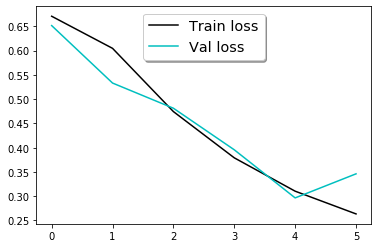

In [706]:
import numpy as np
import matplotlib.pyplot as plt

# Create plots with pre-defined labels.
plt.plot(tr_loss, 'k', label='Train loss')
plt.plot(val_loss, 'c', label='Val loss')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

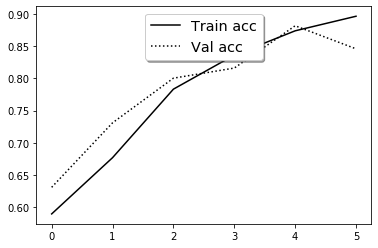

In [707]:
plt.plot(train_accs, 'k', label='Train acc')
plt.plot(val_accs, 'k:', label='Val acc')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

## User Input

We can now use our model to predict the sentiment of any sentence we give it. As it has been trained on movie reviews, the sentences provided should also be movie reviews.

When using a model for inference it should always be in evaluation mode. If this tutorial is followed step-by-step then it should already be in evaluation mode (from doing `evaluate` on the test set), however we explicitly set it to avoid any risk.

Our `predict_sentiment` function does a few things:
- sets the model to evaluation mode
- tokenizes the sentence, i.e. splits it from a raw string into a list of tokens
- indexes the tokens by converting them into their integer representation from our vocabulary
- gets the length of our sequence
- converts the indexes, which are a Python list into a PyTorch tensor
- add a batch dimension by `unsqueeze`ing 
- converts the length into a tensor
- squashes the output prediction from a real number between 0 and 1 with the `sigmoid` function
- converts the tensor holding a single value into an integer with the `item()` method

We are expecting reviews with a negative sentiment to return a value close to 0 and positive reviews to return a value close to 1.

In [0]:
import spacy
nlp = spacy.load('en')

def decode_expl(expl):
  for e in expl:
    print(torch.argsort(e, 0, True)[:10])
    tops = torch.argsort(e, 0, True)
    # vals, idx = e.max(0)
    print(TEXT.vocab.itos[VOCAB[tops[0]]])
    print(TEXT.vocab.itos[VOCAB[tops[1]]])
    print(TEXT.vocab.itos[VOCAB[tops[2]]])
  # print("**")
  # print(expl.size())
  # vals, idx = torch.mean(expl,0).max(0)
  # tops = torch.argsort(expl, 0, True)
  # # print(tops[:5])
  # print(TEXT.vocab.itos[VOCAB[tops[0]]])
  # print(TEXT.vocab.itos[VOCAB[tops[1]]])
  # print(TEXT.vocab.itos[VOCAB[tops[2]]])

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    pred, expl = model(tensor, length_tensor)
    decode_expl(expl[0])
    prediction = torch.sigmoid(pred)
    return prediction.item()

In [709]:
torch.save(model, "model-sa-2.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-pack

In [0]:
model_loaded = torch.load("model-sa-2.pt")

An example negative review...

In [711]:
a=torch.tensor([[1,2,3],[0.3,5,5]])
print(a.max(1))

torch.return_types.max(
values=tensor([3., 5.]),
indices=tensor([2, 2]))


In [712]:
TEXT.vocab.itos[VOCAB[141]]

'favorite'

In [731]:
predict_sentiment(model, "This film is terrible")

tensor([145, 110, 188, 101,  59, 166,  65,   1, 190,  54], device='cuda:0')
enjoyed
excellent
strange
tensor([145, 110, 188, 101,  59, 166,  65,   1, 190, 112], device='cuda:0')
enjoyed
excellent
strange
tensor([145, 110, 188, 101,  59, 166,   1,  65, 190, 112], device='cuda:0')
enjoyed
excellent
strange
tensor([145, 110, 188, 101,   1, 166, 190,  59,  65, 135], device='cuda:0')
enjoyed
excellent
strange


0.03083152510225773

An example positive review...

In [748]:
predict_sentiment(model, "glorious robust crucial")

tensor([  6, 113, 146,  32,  11, 175,  33, 128, 158, 104], device='cuda:0')
worst
played
fine
tensor([  6,  32, 113, 146,  11,  33, 125, 175,  72, 128], device='cuda:0')
worst
played
played
tensor([  6,  32, 113, 146,  11, 125, 175,  33, 128,  72], device='cuda:0')
worst
played
played


0.9737106561660767

In [744]:
predict_sentiment(model, "glorious")

tensor([  6, 113, 146,  32, 175, 158, 104,  11, 128, 161], device='cuda:0')
worst
played
fine


0.8586602210998535

In [734]:
predict_sentiment(model, "robust")

tensor([161,  56, 146,   6,  32,  72,  91,  22, 188, 113], device='cuda:0')
wrong
lost
fine


0.8551093339920044

In [732]:
predict_sentiment(model, "This film is great")

tensor([145, 188, 110,  59, 101, 166,  65,   1, 190, 182], device='cuda:0')
enjoyed
strange
excellent
tensor([145, 188, 110, 101,  59, 166,  65,   1, 190, 182], device='cuda:0')
enjoyed
strange
excellent
tensor([145, 188, 101, 110, 190, 166,   1,  59,  65, 135], device='cuda:0')
enjoyed
strange
good
tensor([145, 101, 188, 110,   1, 166, 190,  65,  59, 129], device='cuda:0')
enjoyed
good
strange


0.9854404330253601

## Next Steps

We've now built a decent sentiment analysis model for movie reviews! In the next notebook we'll implement a model that gets comparable accuracy with far fewer parameters and trains much, much faster.